In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
# --- NEW: Import for Class Weighting ---
from sklearn.utils import class_weight
# --- REMOVED: tensorflow_addons ---

# --- REVISED: Use ResNet50 for lower complexity
from tensorflow.keras.applications import ResNet50
# --- NEW: Imports for SE-Attention Block ---
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Activation, Dropout, Reshape, Multiply
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory, to_categorical
# --- Note: Use resnet_preprocess regardless of 50 or 101
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
# --- MODIFIED: Import ModelCheckpoint ---\
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
# --- NEW: Import for the SGD optimizer ---\
from tensorflow.keras.optimizers import SGD

# --- CONFIGURATION AND CONSTANTS ---

# !!! KAGGLE PATH UPDATED !!!
DATA_DIR = r'/kaggle/input/cancerclassification/Classification/Image'

# --- MODEL CONSTANTS ---\
# 徴 VRAM FIX: Reduced image size from (128, 128) -> Using 224 for Kaggle
IMAGE_SIZE = (224, 224)
# 徴 VRAM FIX: Reduced batch size from 8 -> Using 32 for Kaggle
BATCH_SIZE = 64
CLASSES = ['Normal', 'Benign', 'Malignant']
NUM_CLASSES = len(CLASSES)
# 検 REVISED: Increased L2 strength
L2_REG = 0.05

# --- TRAINING CONSTANTS (TWO-STAGE) ---\
INITIAL_EPOCHS = 10
TOTAL_EPOCHS = 50
FINE_TUNE_EPOCHS = TOTAL_EPOCHS - INITIAL_EPOCHS
INITIAL_LR = 0.001       # For Head-Only Training (Stage 1)
FINE_TUNE_LR = 0.00001   # For Fine-Tuning (Stage 2)
# 検 REVISED: Increased Dropout rate
DROPOUT_RATE = 0.5

# --- NEW: Constants for new features ---
FOCAL_LOSS_GAMMA = 2.0  # Common value for gamma

# --- ENVIRONMENT SETUP ---\
def setup_environment():
    """Clears session and configures GPU/DirectML memory growth, and enables mixed precision."""
    tf.keras.backend.clear_session()

    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Using {len(gpus)} GPU(s) with memory growth enabled.")

            # --- CRITICAL FIX: ENABLE MIXED PRECISION (FP16) FOR VRAM OPTIMIZATION ---
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            print("Enabled Mixed Precision (float16) policy for VRAM reduction.")

        except RuntimeError as e:
            print(e)
    else:
        print("No GPU detected. Using CPU.")
        tf.keras.mixed_precision.set_global_policy('float32') # Ensure policy is clean on CPU

# --- CALLBACKS ---\
# 検 REVISED: Lower patience to 3 to stop training sooner.
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# --- 徴 NEW: Automated Checkpoint Callback ---
# This saves the model weights *only* when val_loss improves
checkpoint_callback = ModelCheckpoint(
    # --- FIX: Changed filepath to end in .weights.h5 ---
    filepath='resnet50_best_weights.weights.h5',  
    save_weights_only=True,             
    monitor='val_loss',                 
    mode='min',                         
    save_best_only=True,                
    verbose=1                           
)


In [2]:
# --- DATA LOADING AND PREPROCESSING FUNCTIONS ---\

# --- FIX: Added 'repeat' parameter ---
def prepare_ds(ds, shuffle=False, repeat=False):
    """Applies ResNet preprocessing, batches, and prefetches the dataset."""
    ds = ds.map(lambda x, y: (resnet_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    
    ds = ds.batch(BATCH_SIZE)
    
    # --- FIX: Add repeat() to make the dataset reusable ---
    if repeat:
        ds = ds.repeat()
        
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

def load_and_split_data(data_dir, classes, image_size):
    """Loads the full dataset and manually splits it (80/10/10)."""
    print("Loading dataset...")
    full_ds = image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        class_names=classes,
        image_size=image_size,
        interpolation='bilinear',
        batch_size=None,
        shuffle=True,
        seed=42
    )
    ds_size = tf.data.experimental.cardinality(full_ds).numpy()

    if ds_size == -1 or ds_size == 0:
        print(f"Warning: Dataset size is unknown or zero. Cannot split.")
        return None, None, None, 0

    train_size = int(0.8 * ds_size)
    val_size = int(0.1 * ds_size)
    test_size = ds_size - train_size - val_size
    train_ds_raw = full_ds.take(train_size)
    val_ds_raw = full_ds.skip(train_size).take(val_size)
    test_ds_raw = full_ds.skip(train_size + val_size)

    print(f"Data split: Total={ds_size}, Train={train_size}, Validation={val_size}, Test={test_size}")
    return train_ds_raw, val_ds_raw, test_ds_raw, ds_size

# --- NEW: Function to calculate class weights ---
def calculate_class_weights(dataset_raw, num_classes):
    """Calculates class weights from a raw (unbatched) tf.data.Dataset."""
    print("Calculating class weights...")
    try:
        labels = np.array([y.numpy() for x, y in dataset_raw])
    except tf.errors.InvalidArgumentError:
        print("Error during label extraction. Ensure dataset is not empty.")
        return None
    class_indices = np.argmax(labels, axis=1)
    unique_classes = np.unique(class_indices)
    if len(unique_classes) < num_classes:
        print(f"Warning: Training data only contains {len(unique_classes)} out of {num_classes} classes.")
    weights = class_weight.compute_class_weight(
        'balanced',
        classes=np.arange(num_classes), 
        y=class_indices
    )
    class_weight_dict = dict(enumerate(weights))
    print(f"Computed class weights: {class_weight_dict}")
    return class_weight_dict

# --- EXECUTION ---
setup_environment()
train_ds_raw, val_ds_raw, test_ds_raw, ds_size = load_and_split_data(DATA_DIR, CLASSES, IMAGE_SIZE)

class_weights = None
if ds_size > 0:
    train_ds = prepare_ds(train_ds_raw, shuffle=True, repeat=True)
    val_ds = prepare_ds(val_ds_raw, repeat=True) 
    test_ds_prepared = prepare_ds(test_ds_raw, repeat=False) 
    class_weights = calculate_class_weights(train_ds_raw, NUM_CLASSES)
    
    # --- FIX: Calculate steps for model.fit() ---
    train_size = tf.data.experimental.cardinality(train_ds_raw).numpy()
    val_size = tf.data.experimental.cardinality(val_ds_raw).numpy()
    
    STEPS_PER_EPOCH = train_size // BATCH_SIZE
    VALIDATION_STEPS = val_size // BATCH_SIZE
    
    if STEPS_PER_EPOCH == 0: STEPS_PER_EPOCH = 1
    if VALIDATION_STEPS == 0: VALIDATION_STEPS = 1
    
    print(f"Calculated steps: STEPS_PER_EPOCH={STEPS_PER_EPOCH}, VALIDATION_STEPS={VALIDATION_STEPS}")
    
else:
    print("Skipping data preparation and weight calculation as no data was loaded.")

Using 2 GPU(s) with memory growth enabled.
Enabled Mixed Precision (float16) policy for VRAM reduction.
Loading dataset...
Found 1665 files belonging to 3 classes.


I0000 00:00:1763242284.073636      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763242284.074312      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Data split: Total=1665, Train=1332, Validation=166, Test=167
Calculating class weights...
Computed class weights: {0: 1.002257336343115, 1: 0.7816901408450704, 2: 1.3831775700934579}
Calculated steps: STEPS_PER_EPOCH=20, VALIDATION_STEPS=2


In [3]:
# --- MODEL BUILDING AND TRAINING FUNCTIONS ---\

# --- NEW: Squeeze-and-Excitation (SE) Attention Block ---
def se_block(input_tensor, ratio=16):
    """Creates a Squeeze-and-Excitation block."""
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(channels, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return Multiply()([input_tensor, se])


def build_resnet_model(image_size, num_classes, base_model, l2_reg):
    """Builds the transfer learning model with ResNet head, SE block, and stronger regularization."""
    inputs = Input(shape=image_size + (3,))
    x = base_model(inputs, training=False)
    x = se_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(DROPOUT_RATE)(x)
    x = Dense(num_classes, kernel_regularizer=l2(l2_reg), dtype='float32')(x)
    outputs = x # Output logits
    model = Model(inputs, outputs)
    return model

# --- NEW: Manual Focal Loss Implementation ---
def create_focal_loss(gamma=2.0):
    """Creates a focal loss function that works with logits."""
    def focal_loss(y_true, y_pred):
        cce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
        pt = tf.exp(-cce)
        loss = ((1 - pt) ** gamma) * cce
        return tf.reduce_mean(loss)
    return focal_loss

def train_model(train_ds, val_ds, class_weights):
    """Performs two-stage training: Feature Extraction and Fine-Tuning."""

    # 検 REVISED: Load ResNet-50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=IMAGE_SIZE + (3,)
    )

    # --- STAGE 1: Feature Extraction (Head Only) ---
    base_model.trainable = False
    model = build_resnet_model(IMAGE_SIZE, NUM_CLASSES, base_model, L2_REG)

    print("\n--- Starting Stage 1: Feature Extraction (Head Only) ---")

    optimizer_initial = SGD(learning_rate=INITIAL_LR, momentum=0.9)
    model.compile(
        optimizer=optimizer_initial,
        loss=create_focal_loss(gamma=FOCAL_LOSS_GAMMA),
        metrics=['accuracy']
    )

    history_initial = model.fit(
        train_ds,
        epochs=INITIAL_EPOCHS,
        validation_data=val_ds,
        # --- FIX: Added steps_per_epoch and validation_steps ---
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        callbacks=[early_stopping_callback, checkpoint_callback],
        class_weight=class_weights
    )

    # --- STAGE 2: Fine-Tuning ---
    base_model.trainable = True

    set_trainable = False
    for layer in base_model.layers:
        if layer.name == 'conv5_block1_out': # Unfreeze from conv5 block onwards
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    num_unfrozen_layers = sum([layer.trainable for layer in base_model.layers])
    print(f"\n--- Starting Stage 2: Fine-tuning ({FINE_TUNE_EPOCHS} Epochs) ---")
    print(f"Number of unfrozen layers in ResNet-50 base: {num_unfrozen_layers}")

    optimizer_finetune = SGD(learning_rate=FINE_TUNE_LR, momentum=0.9)
    model.compile(
        optimizer=optimizer_finetune,
        loss=create_focal_loss(gamma=FOCAL_LOSS_GAMMA),
        metrics=['accuracy']
    )

    history_fine_tune = model.fit(
        train_ds,
        epochs=TOTAL_EPOCHS,
        initial_epoch=history_initial.epoch[-1] + 1,
        validation_data=val_ds,
        # --- FIX: Added steps_per_epoch and validation_steps ---
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        callbacks=[early_stopping_callback, checkpoint_callback],
        class_weight=class_weights
    )

    return model, history_initial, history_fine_tune

# --- EXECUTION ---
if ds_size > 0:
    final_model, history_initial, history_fine_tune = train_model(train_ds, val_ds, class_weights)
else:
    print("\nSkipping training as no data was loaded.")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

--- Starting Stage 1: Feature Extraction (Head Only) ---
Epoch 1/10


I0000 00:00:1763242307.173992     116 service.cc:148] XLA service 0x78f164014e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763242307.174765     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763242307.174785     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763242309.304982     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/20 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.2148 - loss: 1.3915 

I0000 00:00:1763242317.286956     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3268 - loss: 1.1594
Epoch 1: val_loss improved from inf to 0.79667, saving model to resnet50_best_weights.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 852ms/step - accuracy: 0.3303 - loss: 1.1529 - val_accuracy: 0.5234 - val_loss: 0.7967
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5244 - loss: 0.7783
Epoch 2: val_loss improved from 0.79667 to 0.53984, saving model to resnet50_best_weights.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 664ms/step - accuracy: 0.5258 - loss: 0.7768 - val_accuracy: 0.7500 - val_loss: 0.5398
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5324 - loss: 0.7494
Epoch 3: val_loss improved from 0.53984 to 0.53432, saving model to resnet50_best_weights.weights.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 688ms/step - accuracy: 0.5331 - loss: 0.7476 - val_accuracy: 0.7109 - val_loss: 0.5343
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6336 - loss: 0.6521
Epoch 4: val_loss 


--- Loading best weights for final evaluation ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 34 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 30 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



--- Final Evaluation on Test Set ---

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - accuracy: 0.8055 - loss: 0.4008
Test Loss: 0.3952
Test Accuracy: 0.8024 (from model.evaluate)
Gathering predictions and labels (single-pass)...
Gathering complete.

Classification Report:
               precision    recall  f1-score   support

      Normal       0.85      0.87      0.86        54
      Benign       0.78      0.87      0.82        68
   Malignant       0.86      0.69      0.77        45

    accuracy                           0.82       167
   macro avg       0.83      0.81      0.82       167
weighted avg       0.82      0.82      0.82       167



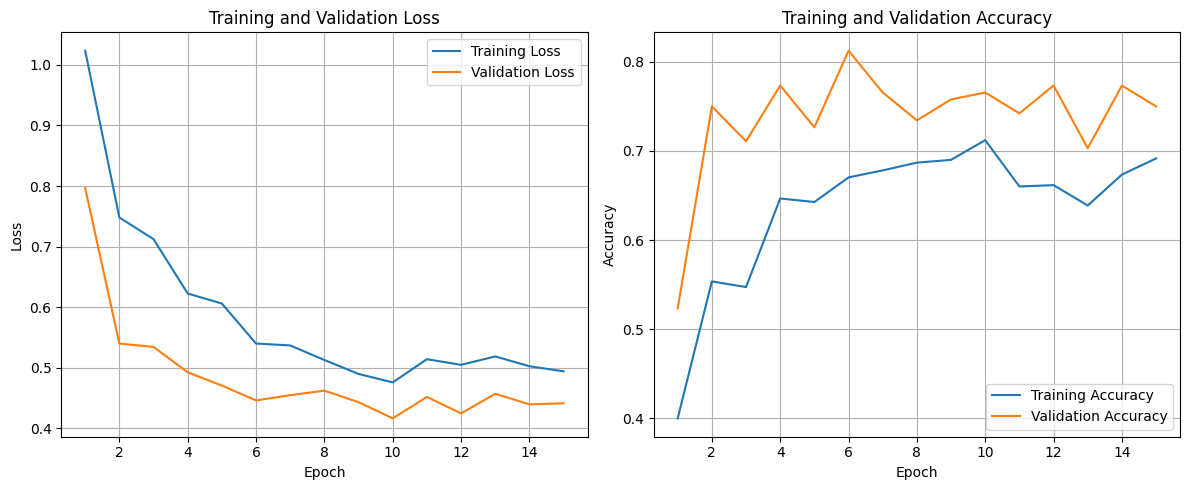

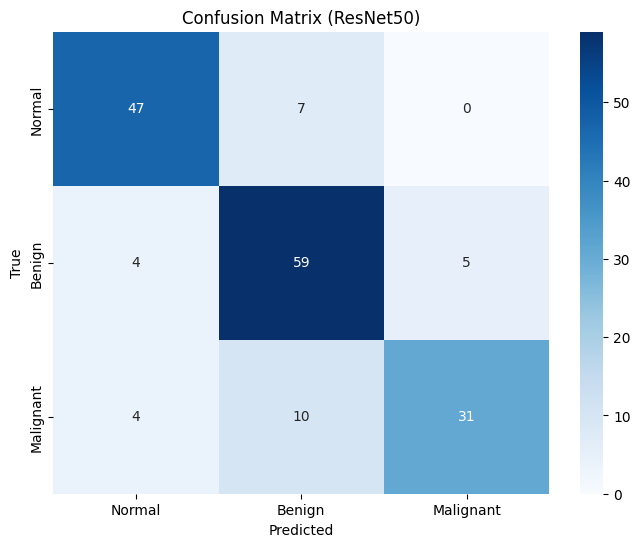

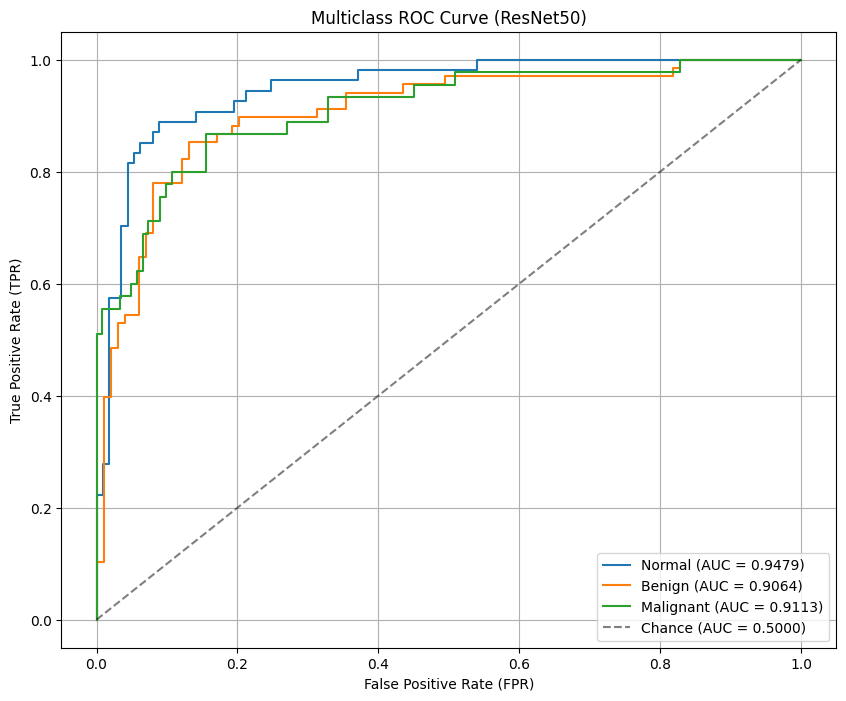

In [13]:
# --- EVALUATION AND PLOTTING FUNCTIONS ---

def combine_history(h1, h2):
    """Combines the history objects from two sequential training stages."""
    combined_history = {}
    for key in h1.history.keys():
        if key in h2.history:
            combined_history[key] = h1.history[key] + h2.history[key]
        else:
            combined_history[key] = h1.history[key]
    return combined_history


# --- 
# --- NEW, CORRECTED FUNCTION (FIXES SHUFFLE BUG)
# ---
def get_predictions_and_labels(test_ds_prepared, model):
    """
    Collects true labels and prediction probabilities by iterating 
    over the prepared dataset *once*. This fixes the shuffle bug.
    """
    print("Gathering predictions and labels (single-pass)...")
    
    y_true_list = []
    y_pred_probs_list = []
    
    # Iterate through the prepared dataset (batched)
    # This ensures we get labels and predictions in the *same order*
    for images, labels in test_ds_prepared:
        # Get true labels for this batch
        y_true_list.append(labels.numpy())
        
        # Get predictions (logits) for this batch
        y_pred_logits = model(images, training=False) 
        
        # Convert logits to probabilities
        y_pred_probs_list.append(tf.nn.softmax(y_pred_logits).numpy())

    # Concatenate all batches from the lists
    y_true_one_hot = np.concatenate(y_true_list, axis=0)
    y_pred_probs = np.concatenate(y_pred_probs_list, axis=0)

    # Get single-class labels
    y_true = np.argmax(y_true_one_hot, axis=1)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("Gathering complete.")
    return y_true, y_pred_probs, y_pred


def plot_learning_curves(h1, h2):
    """Plots the training and validation loss and accuracy."""
    full_history = combine_history(h1, h2)

    actual_epochs = len(full_history.get('loss', []))
    if actual_epochs == 0:
        print("History is empty, skipping plotting.")
        return
        
    epochs_range = range(1, actual_epochs + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, full_history['loss'], label='Training Loss')
    plt.plot(epochs_range, full_history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, full_history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, full_history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("resnet50_learning_curves.png")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix (ResNet50)")
    plt.savefig("resnet50_confusion_matrix.png")
    plt.show()

def plot_roc_curve(y_true_raw, y_pred_probs, classes):
    """Plots the Multiclass ROC Curve (One-vs-Rest)."""
    y_true_one_hot = to_categorical(y_true_raw, num_classes=NUM_CLASSES)

    plt.figure(figsize=(10, 8))

    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
        roc_auc = roc_auc_score(y_true_one_hot[:, i], y_pred_probs[:, i])
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5000)', alpha=0.5)

    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Multiclass ROC Curve (ResNet50)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig("resnet50_roc_curve.png")
    plt.show()

# --- FINAL EVALUATION EXECUTION ---
if ds_size > 0:
    print("\n--- Loading best weights for final evaluation ---")
    
    # Load the best weights saved by the checkpoint
    final_model.load_weights('resnet50_best_weights.weights.h5')
    
    print("\n--- Final Evaluation on Test Set ---\n")
    # This result is from ONE shuffle of the test set
    test_results = final_model.evaluate(test_ds_prepared, verbose=1)
    print(f"Test Loss: {test_results[0]:.4f}")
    print(f"Test Accuracy: {test_results[1]:.4f} (from model.evaluate)")

    # --- 
    # --- UPDATED CALL: Use the new function and pass *only* test_ds_prepared
    # --- This will run on a *different* shuffle, but labels/preds will be synced.
    y_true, y_pred_probs, y_pred = get_predictions_and_labels(test_ds_prepared, final_model)

    # Check if predictions were successful
    if y_true.size > 0:
        print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=CLASSES))

        plot_learning_curves(history_initial, history_fine_tune)
        plot_confusion_matrix(y_true, y_pred, CLASSES)
        plot_roc_curve(y_true, y_pred_probs, CLASSES)
    else:
        print("Skipping report and plots due to prediction error.")
else:
    print("\nSkipping final evaluation and plotting.")